In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data_plos_one_2015_anon.csv", sep=";")

In [3]:
error= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SPeC_left_UKB_16-37-36_150/epilepsy_PBS/Reconstruction_error.csv")

In [13]:
error

,Index,0
0,control01,5144.727539
1,control02,4656.384766
2,control03,4031.201904
3,control04,3678.619385
4,control05,5409.839355
5,control06,4417.740234
6,control07,5063.406250
7,control08,5390.479004
8,control09,5486.647461
9,control10,5034.658203


In [4]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")


In [5]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]
epilepsy_irm_neg= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_negatives_centrales"]
epilepsy_irm_pos= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_positives_centrales"]

In [6]:
error  = error.rename(columns={error.columns[0]: "Index"})


In [7]:
df = df.rename(columns={df.columns[0]: "Index"})


In [8]:
error_controls = error.merge(epilepsy_controls[["Index"]], on="Index", how="inner")
error_irm_neg = error.merge(epilepsy_irm_neg[["Index"]], on="Index", how="inner")
error_irm_pos = error.merge(epilepsy_irm_pos[["Index"]], on="Index", how="inner")

In [9]:
df_neg= df.merge(error_irm_neg, on ="Index", how="inner")
df_pos= df.merge(error_irm_pos, on ="Index", how="inner")

In [10]:
df_neg = df_neg.rename(columns={'0': 'error'})
df_pos = df_pos.rename(columns={'0': 'error'})

In [11]:
df_neg_D = df_neg[df_neg['lesion_side']=='D']
df_neg_G = df_neg[df_neg['lesion_side']=='G']

df_pos_D = df_pos[df_pos['lesion_side']=='D']
df_pos_G = df_pos[df_pos['lesion_side']=='G']

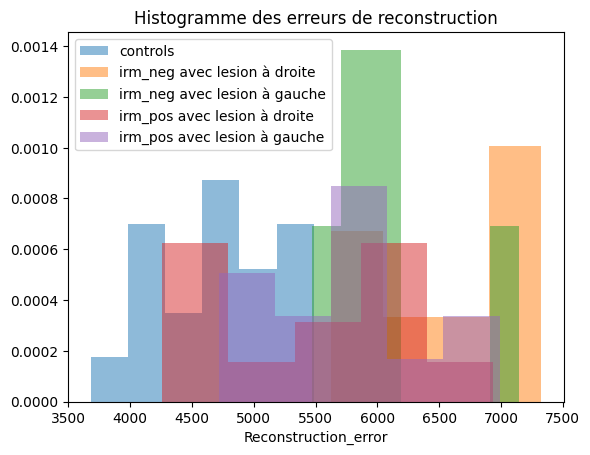

In [12]:
plt.hist(error_controls.iloc[:,1], bins="auto", alpha=0.5, label="controls", density=True)
plt.hist(df_neg_D['error'], bins="auto", alpha=0.5, label="irm_neg avec lesion à droite", density=True)
plt.hist(df_neg_G['error'], bins="auto", alpha=0.5, label="irm_neg avec lesion à gauche", density=True)
plt.hist(df_pos_D['error'], bins="auto", alpha=0.5, label="irm_pos avec lesion à droite", density=True)
plt.hist(df_pos_G['error'], bins="auto", alpha=0.5, label="irm_pos avec lesion à gauche", density=True)

plt.xlabel("Reconstruction_error")

plt.title("Histogramme des erreurs de reconstruction (cross entropy)")
plt.legend()
plt.show()

Distance de chamfer

In [ ]:
import os
from scipy.ndimage import distance_transform_edt
from numpy.lib.stride_tricks import sliding_window_view

In [ ]:
index_irm_neg_D = [19,28,31,34,41,43,44]
index_irm_neg_G = [21,26,35,38,40,45]

index_irm_pos_D=[20,23,24,25,27,29,32,33,36,51,55,56]
index_irm_pos_G=[22,30,37,39,42,46,47,48,49,50,52,53,54]

In [ ]:
def edge_distance_kernel(mask, distance_threshold=5.0, sigma=2.0):
    """
    Compute a spatial weighting kernel emphasizing the center of a binary mask.
    Inside the mask:
      - Weights = 1 for pixels farther than `distance_threshold` from the edge.
      - Weights = Gaussian decay for pixels within `distance_threshold` of the edge.
    Outside the mask:
      - Weights = 0.
    Parameters
    ----------
    mask : np.ndarray
        2D or 3D binary mask defining the valid region (1 inside, 0 outside).
    distance_threshold : float
        Distance (in pixels/voxels) from the mask edge above which weight = 1.
    sigma : float
        Gaussian falloff width (controls how fast the weight decays near edges).
    Returns
    -------
    kernel : np.ndarray
        Weight map of same shape as `mask`, values in [0,1].
    """
    assert mask.ndim in (2, 3), "mask must be 2D or 3D"
    mask = (mask > 0).astype(np.uint8)
    # Compute distance to the nearest 0 (edge)
    dist_inside = distance_transform_edt(mask)
    # Gaussian decay near the edge
    kernel = np.ones_like(mask, dtype=float)
    near_edge = dist_inside < distance_threshold
    kernel[near_edge] = np.exp(-((distance_threshold - dist_inside[near_edge]) ** 2) / (2 * sigma ** 2))
    # Zero weight outside the mask
    kernel[mask == 0] = 0.0
    return kernel

In [ ]:
def chamfer_sweep_weighted(
    binary,
    reconstruction,
    threshold=0.55,
    kernel=None,
    two_sided=True
):
    """
    Compute weighted Chamfer distance between a binary mask and thresholded
    reconstructions over a range of thresholds.
    Parameters
    ----------
    binary : np.ndarray
        2D or 3D binary ground truth (0/1).
    reconstruction : np.ndarray
        2D or 3D continuous reconstruction in [0,1].
    kernel : np.ndarray or None
        Weighting map of same shape as input. If None, use uniform weights = 1.
    two_sided : bool
        Whether to compute symmetric Chamfer (True) or one-sided (False).
    local_window : int or None
        If None, returns mean error per threshold (scalar).
        If int, compute the sum of weighted error in each valid window
        (no padding) and take the maximum as the score.
    """
    assert binary.shape == reconstruction.shape, "Shapes must match"
    assert binary.ndim in (2, 3), "Supports only 2D or 3D arrays"
    binary = (binary > 0.5).astype(np.uint8)
    if kernel is None:
        kernel = np.ones_like(binary, dtype=float)
    else:
        assert kernel.shape == binary.shape, "Kernel must have same shape as input"
    dist_bin = distance_transform_edt(1 - binary)


    recon_bin = (reconstruction > threshold).astype(np.uint8)
    dist_recon = distance_transform_edt(1 - recon_bin)
    if two_sided:
        error_map = binary * dist_recon + recon_bin * dist_bin
    else:
        error_map = recon_bin * dist_bin
    weighted_error = error_map * kernel

    chamfer_score = weighted_error.mean()

    return chamfer_score

In [ ]:
def transform_mask(mask, input):

    target_shape = input[0].shape

    pad_width = [(0, t - s) for s, t in zip(mask.shape, target_shape)]

    mask = np.pad(mask, pad_width, mode='constant', constant_values=0)
    return mask

In [ ]:
input_epilepsy= np.load("/neurospin/tmp/fred/models/2025-11-10/SPeC_left_UKB_16-37-36_150/epilepsy_PBS/inputs.npy")
output_epilepsy= np.load("/neurospin/tmp/fred/models/2025-11-10/SPeC_left_UKB_16-37-36_150/epilepsy_PBS/outputs.npy")

In [ ]:
input_epilepsy = input_epilepsy[:,0,:,:,:]
output_epilepsy = output_epilepsy[:,1,:,:,:]


In [ ]:
input_control = input_epilepsy[0:19,:,:,:]
input_neg_D= input_epilepsy[index_irm_neg_D,:,:,:]
input_neg_G= input_epilepsy[index_irm_neg_G,:,:,:]
input_pos_D= input_epilepsy[index_irm_pos_D,:,:,:]
input_pos_G= input_epilepsy[index_irm_pos_G,:,:,:]

output_control = output_epilepsy[0:19,:,:,:]
output_neg_D= output_epilepsy[index_irm_neg_D,:,:,:]
output_neg_G= output_epilepsy[index_irm_neg_G,:,:,:]
output_pos_D= output_epilepsy[index_irm_pos_D,:,:,:]
output_pos_G= output_epilepsy[index_irm_pos_G,:,:,:]


In [ ]:
chamfer_control = []
chamfer_neg_D=[]
chamfer_neg_G=[]
chamfer_pos_D=[]
chamfer_pos_G=[]

In [ ]:
mask= np.load("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/crops/2mm/S.Pe.C./mask/Lmask.npy")

In [ ]:
mask= transform_mask(mask,input_control)

In [ ]:
kernel=edge_distance_kernel(mask)

In [ ]:
for j in range(input_control.shape[0]):
    chamfer_control.append(chamfer_sweep_weighted(input_control[j,:,:,:], output_control[j,:,:,:], 0.55, kernel))

for j in range(input_neg_D.shape[0]):
    chamfer_neg_D.append(chamfer_sweep_weighted(input_neg_D[j,:,:,:], output_neg_D[j,:,:,:], 0.55,kernel))

for j in range(input_neg_G.shape[0]):
    chamfer_neg_G.append(chamfer_sweep_weighted(input_neg_G[j,:,:,:], output_neg_G[j,:,:,:], 0.55,kernel))

for j in range(input_pos_D.shape[0]):
    chamfer_pos_D.append(chamfer_sweep_weighted(input_pos_D[j,:,:,:], output_pos_D[j,:,:,:], 0.55,kernel))

for j in range(input_pos_G.shape[0]):
    chamfer_pos_G.append(chamfer_sweep_weighted(input_pos_G[j,:,:,:], output_pos_G[j,:,:,:], 0.55,kernel))